In [ ]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

Individual model components and combined model

In [ ]:
# 1. Planktonic growth rate (Monod-logistic)
def planktonic_growth(N, Bp, max_growth_rate_p, K_S, K_p):
    """
    Monod-logistic growth rate for planktonic bacteria.
    μ_p = μ_max_p * (N / (K_S + N)) * (1 - (Bp / K_p))
    @param N: nutrient concentration in the lake environment (mg/mL)

    @param Bp: Planktonic biomass concentration (mg/mL)
    @param K_S: Half-saturation constant (nutrient concentration at which the growth rate is half of max_growth_rate_p) (mg/mL)
    @param K_p: Carrying capacity of the freshwater environment (based on temperature, light exposure, and nutrient availability)
    """
    if Bp < 0:
      print("Bp is less than 0")
    return max_growth_rate_p * (N / (K_S + N)) * (1 - (Bp / K_p))

# 2. Biofilm growth rate (Contois-logistic model)
def biofilm_growth(N, Bb, max_growth_rate_b, K_S, Kb_t):
    """
    Contois growth rate for biofilm bacteria.
    μ_b = μ_max_b * (N / (K_S * Bb + N)) * (1 - Bb / Kb_t)
    @param N: nutrient concentration in the lake environment (mg/mL)
    @param Bb: Biofilm mass concentration (mg/mL)
    @param K_S: Half-saturation constant (nutrient concentration at which the growth rate is half of max_growth_rate_p (mg/mL)
    @param Kb_t: Carrying capacity of the biofilm (as a function of microplastic concentration)
    """
    if Bb < 0:
      print("Bb is less than 0")
    return max_growth_rate_b * (N / (K_S * Bb + N)) * (1 - Bb / Kb_t)

# 3. Adhesion rate adjustment based on contact angles (Wenzel model)
def adhesion_rate(theta_ref, theta_w, base_rate):
    """
    Adhesion rate modifier: k_a(theta_w) = base_rate * (theta_ref / theta_w)
    @param base_rate: Baseline adhesion constant at which a specific bacteria sticks to a surface without effects of contact angle
    @param theta_ref: The reference contact angle of the microplastic, prior to bacterial adhesion on its surface
    @param theta_w: Measured contact angle of the microplastic, after biofilm formation has begun on its surface
    """
    return base_rate * (theta_w / theta_ref)

# 4. Available microplastic surface area (abbreviated as MSA)
def microplastic_surface_area(a_surface, M_conc, Bb, b_surface):
    """
    MSA(t) = a_surface * M_conc - (Bb / b_surface) #(the total surface area of microplastics) - (the surface area already taken by biofilm)
    @param a_surface - Microplastic surface area per unit of microplastic mass (cm^2/mg)
    @param M_conc - Microplastic concentration (mg/mL)
/    @param b_surface - Biofilm mass per surface area (CFU/cm^2)
    """
    MSA = (a_surface * M_conc) - (Bb / b_surface)
    return max(MSA, 0.0) #to ensure non-negative available surface area

# 5. Dynamic carrying capacity for biofilm (based on available surface area)
def carrying_capacity_biofilm(MSA, b_max):
    """
    Kb(t) = b_max * MSA
    @param b_max: Maximum biomass per unit surface area (mg/cm^2)
    @param MSA: microplastic surface area available (cm^2/mL)
    """
    return b_max * MSA

# 6. Combined ODE system
def combined_model(t, y, params):
    """
    y: [Bp, Bb] where  Bb is the biofilm mass concentration and Bp is planktonic biomass concentration
    @params: contains all parameters from the various equations
    """
    Bp, Bb = y
    # Unpack parameters from the "params" passed in
    N = params['N_conc']
    M = params['M_conc']
    max_growth_rate_p = params['max_growth_rate_p']
    K_S = params['K_S']
    K_p = params['K_p']
    max_growth_rate_b = params['max_growth_rate_b']
    a_surface = params['a_surface']
    b_surface = params['b_surface']
    b_max = params['b_max']
    k_A_base = params['k_A_base']
    theta_ref = params['theta_ref']
    theta_w = params['theta_w']
    k_D = params['k_D']

    # Calculate the 5 models above using parameters
    k_A = adhesion_rate(theta_ref, theta_w, k_A_base)
    MSA = microplastic_surface_area(a_surface, M, Bb, b_surface)
    Kb_t = carrying_capacity_biofilm(MSA, b_max)
    mu_p = planktonic_growth(N, Bp, max_growth_rate_p, K_S, K_p)
    mu_b = biofilm_growth(N, Bb, max_growth_rate_b, K_S, Kb_t)


    dBp_dt = mu_p * Bp - k_A * Bp + k_D * Bb #rate of change in planktonic biomass concentration
    dBb_dt = mu_b * Bb + k_A * Bp - k_D * Bb #rate of change in biofilm mass concentration

    return [dBp_dt, dBb_dt]

Parameters

In [ ]:
# Setting default parameters as an example
params = {
    'N_conc': 0.1022,
    'M_conc': 14608,
    'max_growth_rate_p': 0.5,
    'K_S': 0.5,
    'K_p': 467995000,              # carrying capacity
    'max_growth_rate_b': 2240,
    'a_surface': 10.0,         # cm²/mg of plastic
    'b_surface': 0.05,
    'b_max': 1462500000,             # mg/cm²
    'k_A': 0.05,
    'theta_ref': 95.0,
    'theta_w': 80.0,
    'k_D': 0.02                # slow detachment
}

# Initial conditions and time span
y0 = [0.5, 0.05]       # [Bp0, Bb0] in mgmL
t_span = (0, 30)       # simulate for 1 month

# Solve the ODE system which is our main model

solution = solve_ivp(
    fun=lambda t, y: combined_model(t, y, params), #using lambda to wrap our combined model into a function with 2 arguments instead of 3 (so we are able to pass our extra parameters)
    t_span=t_span,
    y0=y0
)

# Output basic results
print("Time points:", solution.t)
print("Planktonic biomass (Bp):", solution.y[0])
print("Biofilm biomass (Bb):", solution.y[1])
t = solution.t
Bp = solution.y[0]
Bb = solution.y[1]


KeyError: 'k_A_base'

Actual Model Plotted

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.dates import DateFormatter


plt.title('Biofilm Growth Trends (log10 CFU/mL)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('log10 CFU/mL', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('biofilm_trends.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Phase Analysis (Automatic detection)
df['YearMonth'] = df['Date'].dt.to_period('M')
monthly_avg = df.groupby('YearMonth').mean(numeric_only=True)

# Detect phases based on slope changes
def detect_phases(series):
    """Identify phases using piecewise regression"""
    # Simplified approach - customize as needed
    if series.name < pd.Period('2016-01'): return 'Colonization'
    elif series.name < pd.Period('2017-06'): return 'Maturation'
    else: return 'Maintenance'

monthly_avg['Phase'] = monthly_avg.index.map(detect_phases)
df = df.merge(monthly_avg['Phase'],
              left_on='YearMonth',
              right_index=True,
              how='left')

# 3. Statistical Analysis
print("\n=== Phase Statistics ===")
for phase in df['Phase'].unique():
    phase_data = df[df['Phase'] == phase]
    print(f"\n{phase} Phase (n={len(phase_data)})")
    print(phase_data[['Reactor1', 'Reactor2', 'Reactor3']].describe())

    # ANOVA between reactors
    f_val, p_val = stats.f_oneway(phase_data['Reactor1'],
                                 phase_data['Reactor2'],
                                 phase_data['Reactor3'])
    print(f"ANOVA: F={f_val:.2f}, p={p_val:.4f}")

# 4. Growth Rate Calculation
growth_rates = pd.DataFrame()
for reactor in ['Reactor1', 'Reactor2', 'Reactor3']:
    growth_rates[f'{reactor}_rate'] = df[reactor].diff() / df['Date'].diff().dt.days

plt.figure(figsize=(14, 5))
for reactor in ['Reactor1', 'Reactor2', 'Reactor3']:
    sns.lineplot(data=df, x='Date', y=growth_rates[f'{reactor}_rate'],
                 label=reactor, color=colors.pop(0))

plt.title('Daily Growth Rates (Δlog10 CFU/mL/day)', fontsize=14)
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.ylabel('Growth Rate', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.tight_layout()
plt.savefig('growth_rates.png', dpi=300)
plt.show()

# 5. Reactor Comparison Boxplot
plt.figure(figsize=(10, 6))
melted = df.melt(id_vars=['Date', 'Phase'],
                value_vars=['Reactor1', 'Reactor2', 'Reactor3'],
                var_name='Reactor',
                value_name='log10_CFU')

sns.boxplot(data=melted, x='Phase', y='log10_CFU', hue='Reactor',
            palette=colors, showfliers=False)
plt.title('Biofilm Concentration by Phase', fontsize=14)
plt.ylabel('log10 CFU/mL', fontsize=12)
plt.xlabel('')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('phase_comparison.png', dpi=300)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/LowerBoundData.xlsx'

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from io import StringIO

# 1. Define the raw data from user
raw_data = """
11/18/2015,2.073333333
11/25/2015,2.65
12/2/2015,2.743333333
12/9/2015,2.95
12/16/2015,2.52
1/6/2016,2.916666667
1/13/2016,2.846666667
1/20/2016,3.43
1/27/2016,3.523333333
2/3/2016,3.523333333
2/10/2016,3.68
2/17/2016,3.653333333
2/24/2016,3.716666667
3/1/2016,3.75
3/8/2016,3.626666667
3/15/2016,3.86
3/22/2016,3.906666667
3/29/2016,4
4/5/2016,3.956666667
4/12/2016,4.076666667
"""

df = pd.read_csv(StringIO(raw_data), header=None, names=["date", "value"])
df["date"] = pd.to_datetime(df["date"])
df["days"] = (df["date"] - df["date"].iloc[0]).dt.days

# 2. Use a simplified version of combined_model for optimization (only planktonic modeled)
def simplified_combined_model(t, y, params):
    Bp, Bb = y
    N = params['N_conc']
    M = params['M_conc']
    max_growth_rate_p = params['max_growth_rate_p']
    K_S = params['K_S']
    K_p = params['K_p']
    max_growth_rate_b = params['max_growth_rate_b']
    a_surface = params['a_surface']
    b_surface = params['b_surface']
    b_max = params['b_max']
    k_A_base = params['k_A_base']
    theta_ref = params['theta_ref']
    theta_w = params['theta_w']
    k_D = params['k_D']

    def planktonic_growth(N, Bp, max_growth_rate_p, K_S, K_p):
        return max_growth_rate_p * (N / (K_S + N)) * (1 - (Bp / K_p))

    def adhesion_rate(theta_ref, theta_w, base_rate):
        return base_rate * (theta_w / theta_ref)

    def microplastic_surface_area(a_surface, M_conc, Bb, b_surface):
        return max((a_surface * M_conc) - (Bb / b_surface), 0.0)

    def carrying_capacity_biofilm(MSA, b_max):
        return b_max * MSA

    def biofilm_growth(N, Bb, max_growth_rate_b, K_S, Kb_t):
        return max_growth_rate_b * (N / (K_S * Bb + N)) * (1 - Bb / Kb_t)

    k_A = adhesion_rate(theta_ref, theta_w, k_A_base)
    MSA = microplastic_surface_area(a_surface, M, Bb, b_surface)
    Kb_t = carrying_capacity_biofilm(MSA, b_max)
    mu_p = planktonic_growth(N, Bp, max_growth_rate_p, K_S, K_p)
    mu_b = biofilm_growth(N, Bb, max_growth_rate_b, K_S, Kb_t)

    dBp_dt = mu_p * Bp - k_A * Bp + k_D * Bb
    dBb_dt = mu_b * Bb + k_A * Bp - k_D * Bb

    return [dBp_dt, dBb_dt]

# 3. Define a cost function
def cost_function(x, t_data, y_data):
    test_params = {
        'N_conc': 0.1022,
        'M_conc': 14608,
        'max_growth_rate_p': x[0],
        'K_S': x[1],
        'K_p': x[2],
        'max_growth_rate_b': 2240,
        'a_surface': 10.0,
        'b_surface': 0.05,
        'b_max': 1462500000,
        'k_A_base': 0.05,
        'theta_ref': 95.0,
        'theta_w': 80.0,
        'k_D': 0.02
    }
    y0 = [y_data[0], 0.05]
    sol = solve_ivp(lambda t, y: simplified_combined_model(t, y, test_params),
                    [t_data[0], t_data[-1]], y0, t_eval=t_data)
    if not sol.success:
        return np.inf
    error = np.mean((sol.y[0] - y_data) ** 2)
    return error

# 4. Optimize the parameters
x0 = [0.5, 0.5, 1e6]  # initial guesses for max_growth_rate_p, K_S, K_p
result = minimize(cost_function, x0, args=(df["days"].values, df["value"].values),
                  bounds=[(0, 5), (0.001, 5), (1e3, 1e9)])

# 5. Return optimized values
optimized_params = {
    'max_growth_rate_p': result.x[0],
    'K_S': result.x[1],
    'K_p': result.x[2]
}

optimized_params_df = pd.DataFrame([optimized_params])
import ace_tools as tools; tools.display_dataframe_to_user(name="Optimized Growth Parameters", dataframe=optimized_params_df)


/tmp/ipython-input-19-3947468165.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  return max_growth_rate_b * (N / (K_S * Bb + N)) * (1 - Bb / Kb_t)
/tmp/ipython-input-19-3947468165.py:65: RuntimeWarning: invalid value encountered in scalar multiply
  return max_growth_rate_b * (N / (K_S * Bb + N)) * (1 - Bb / Kb_t)
/tmp/ipython-input-19-3947468165.py:73: RuntimeWarning: invalid value encountered in scalar subtract
  dBp_dt = mu_p * Bp - k_A * Bp + k_D * Bb
/tmp/ipython-input-19-3947468165.py:65: RuntimeWarning: invalid value encountered in scalar divide
  return max_growth_rate_b * (N / (K_S * Bb + N)) * (1 - Bb / Kb_t)


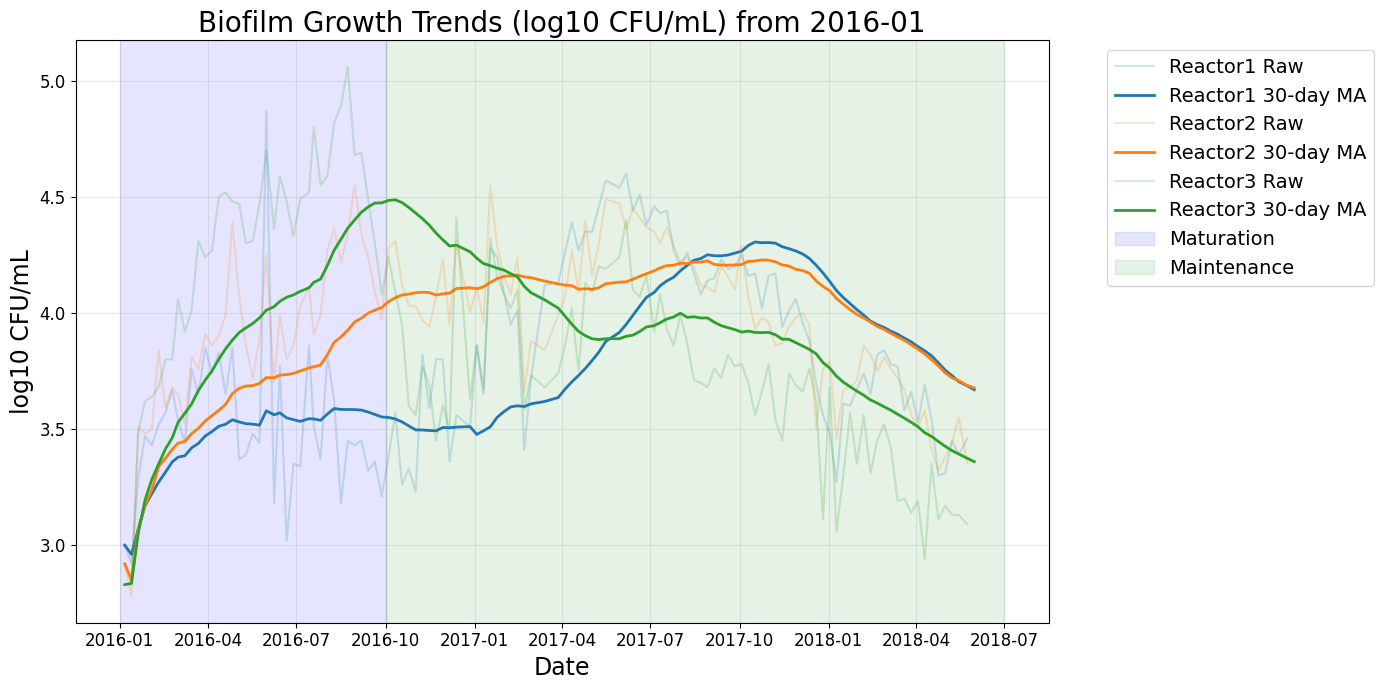


=== Phase Statistics (from 2016-01) ===

Maturation Phase (n=70)
        Reactor1   Reactor2   Reactor3
count  70.000000  70.000000  70.000000
mean    3.683286   3.998571   4.098429
std     0.412285   0.326755   0.448209
min     2.920000   2.780000   2.830000
25%     3.382500   3.860000   3.742500
50%     3.580000   4.015000   4.115000
75%     3.857500   4.240000   4.470000
max     4.870000   4.550000   5.060000
ANOVA: F=20.64, p=0.0000

Maintenance Phase (n=52)
        Reactor1   Reactor2   Reactor3
count  51.000000  51.000000  51.000000
mean    3.927843   3.906471   3.577451
std     0.360030   0.319292   0.335063
min     3.270000   3.320000   2.940000
25%     3.630000   3.675000   3.305000
50%     3.960000   3.930000   3.660000
75%     4.195000   4.180000   3.775000
max     4.600000   4.450000   4.400000
ANOVA: F=17.17, p=0.0000


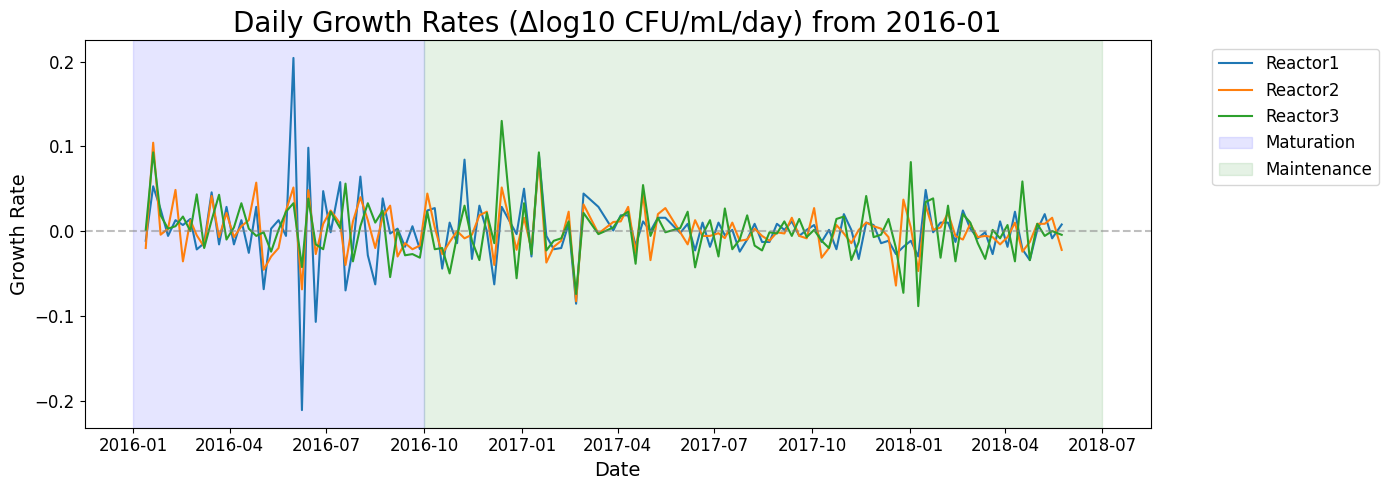

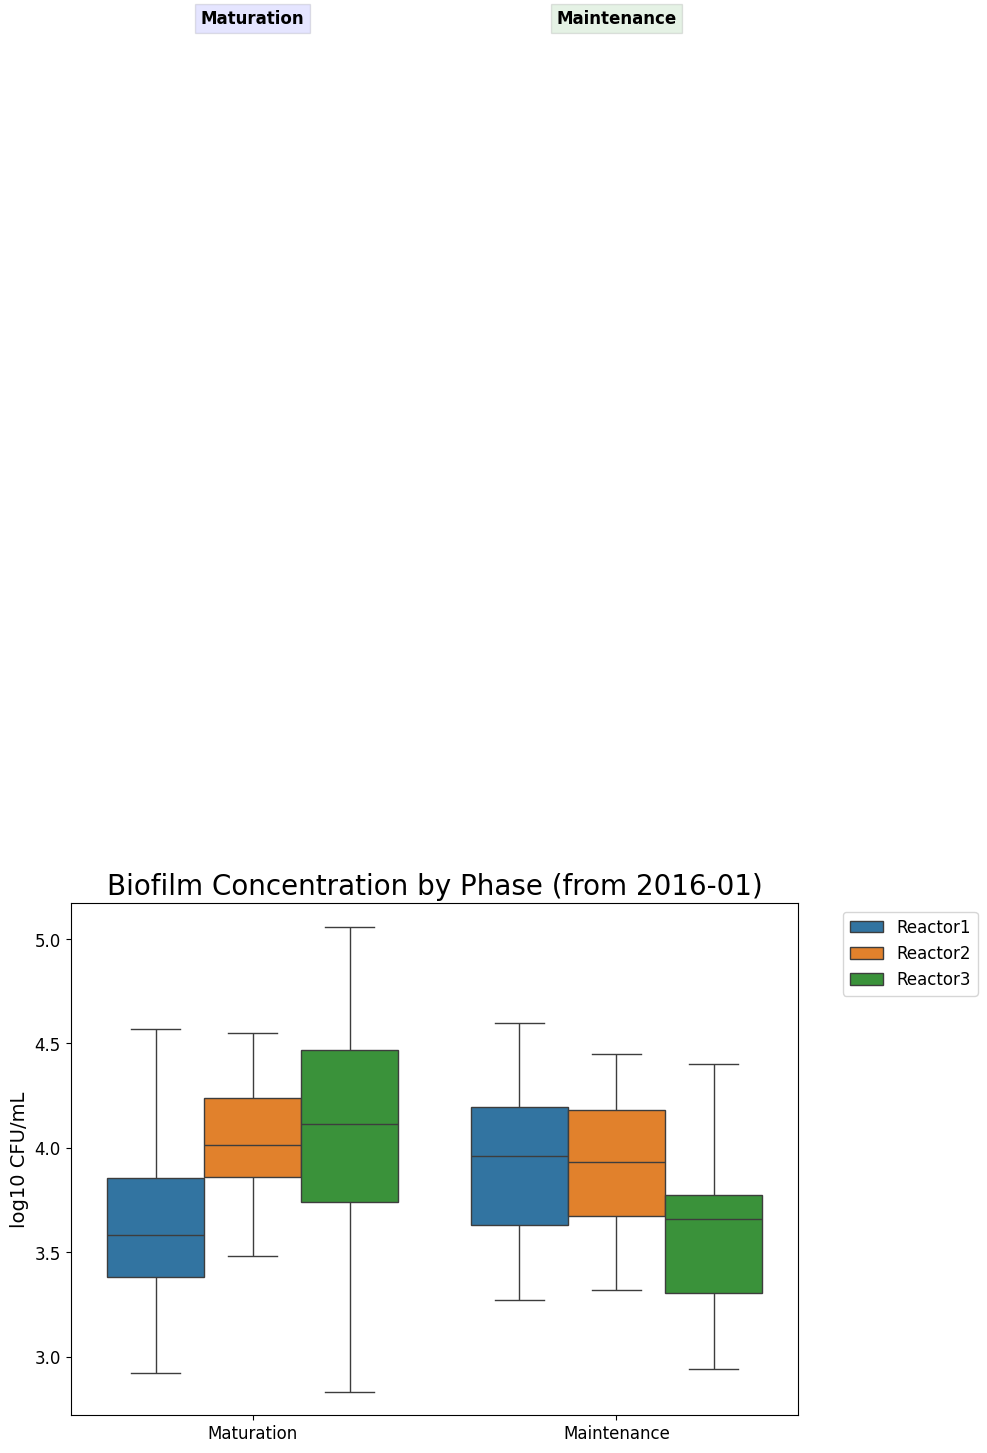

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.dates import DateFormatter
from datetime import datetime
import matplotlib.dates as mdates


# Define start/end dates for shading
maturation_start = datetime(2016, 1, 1)
maturation_end = datetime(2016, 10, 1)
maintenance_end = datetime(2018, 7, 1)

# Load data from Excel file
file_path = '/content/lowerbounddatatuff.xlsx'  # Change to your file path
# Read the Excel file, skipping the first row and providing explicit column names
df = pd.read_excel(file_path, skiprows=[0], names=['Date', 'Reactor 1', 'Reactor 2', 'Reactor 3'], parse_dates=['Date'])

# Rename columns to remove spaces for easier access
df.rename(columns={'Reactor 1': 'Reactor1', 'Reactor 2': 'Reactor2', 'Reactor 3': 'Reactor3'}, inplace=True)

# Data cleaning (handle zeros if needed)
df.replace(0, np.nan, inplace=True)  # Optional: treat zeros as missing data

# Convert reactor columns to numeric, coercing errors
for reactor in ['Reactor1', 'Reactor2', 'Reactor3']:
    df[reactor] = pd.to_numeric(df[reactor], errors='coerce')

# Filter data to start from 2016-01-01
start_date = '2016-01-01'
df_filtered = df[df['Date'] >= start_date].copy()


# 1. Time-Series Plot with Moving Averages
plt.figure(figsize=(14, 7))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Colorblind-friendly palette

for i, reactor in enumerate(['Reactor1', 'Reactor2', 'Reactor3']):
    # Raw data
    plt.plot(df_filtered['Date'], df_filtered[reactor],
             color=colors[i], alpha=0.2,
             label=f'{reactor} Raw')

    # 30-day moving average
    ma = df_filtered[reactor].rolling(window=30, min_periods=1).mean()
    plt.plot(df_filtered['Date'], ma,
             color=colors[i], linewidth=2,
             label=f'{reactor} 30-day MA')

# Add shading (inside plots)
plt.axvspan(mdates.date2num(maturation_start), mdates.date2num(maturation_end), color='blue', alpha=0.1, label='Maturation')
plt.axvspan(mdates.date2num(maturation_end), mdates.date2num(maintenance_end), color='green', alpha=0.1, label='Maintenance')

plt.title('Biofilm Growth Trends (log10 CFU/mL) from 2016-01', fontsize=20)
plt.xlabel('Date', fontsize=17)
plt.ylabel('log10 CFU/mL', fontsize=17)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.grid(True, alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=12) # Increase tick label size
plt.tight_layout()
plt.savefig('biofilm_trends_2016.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Phase Analysis (Automatic detection)
df_filtered['YearMonth'] = df_filtered['Date'].dt.to_period('M')
monthly_avg_filtered = df_filtered.groupby('YearMonth').mean(numeric_only=True)

# Detect phases based on slope changes
def detect_phases(period):
    """Identify phases using piecewise regression"""
    # Simplified approach - customize as needed
    if period < pd.Period('2017-06', freq='M'): return 'Maturation'
    else: return 'Maintenance'

monthly_avg_filtered['Phase'] = monthly_avg_filtered.index.map(detect_phases)
df_filtered = df_filtered.merge(monthly_avg_filtered['Phase'],
              left_on='YearMonth',
              right_index=True,
              how='left')


# 3. Statistical Analysis
print("\n=== Phase Statistics (from 2016-01) ===")
for phase in df_filtered['Phase'].unique():
    phase_data = df_filtered[df_filtered['Phase'] == phase]
    print(f"\n{phase} Phase (n={len(phase_data)})")
    print(phase_data[['Reactor1', 'Reactor2', 'Reactor3']].describe())

    # ANOVA between reactors
    # Drop NaN values before performing ANOVA
    reactor1_data = phase_data['Reactor1'].dropna()
    reactor2_data = phase_data['Reactor2'].dropna()
    reactor3_data = phase_data['Reactor3'].dropna()

    # Check if there is enough data for ANOVA
    if len(reactor1_data) > 0 and len(reactor2_data) > 0 and len(reactor3_data) > 0:
        f_val, p_val = stats.f_oneway(reactor1_data,
                                     reactor2_data,
                                     reactor3_data)
        print(f"ANOVA: F={f_val:.2f}, p={p_val:.4f}")
    else:
        print("Not enough data to perform ANOVA for this phase.")


# 4. Growth Rate Calculation
growth_rates_filtered = pd.DataFrame()
for reactor in ['Reactor1', 'Reactor2', 'Reactor3']:
    growth_rates_filtered[f'{reactor}_rate'] = df_filtered[reactor].diff() / df_filtered['Date'].diff().dt.days
plt.figure(figsize=(14, 5))

# Reset the color palette for the second plot
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for reactor in ['Reactor1', 'Reactor2', 'Reactor3']:
    sns.lineplot(data=df_filtered, x='Date', y=growth_rates_filtered[f'{reactor}_rate'],
                 label=reactor, color=colors.pop(0))

# Add shading (inside plots)
plt.axvspan(mdates.date2num(maturation_start), mdates.date2num(maturation_end), color='blue', alpha=0.1, label='Maturation')
plt.axvspan(mdates.date2num(maturation_end), mdates.date2num(maintenance_end), color='green', alpha=0.1, label='Maintenance')


plt.title('Daily Growth Rates (Δlog10 CFU/mL/day) from 2016-01', fontsize=20)
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.ylabel('Growth Rate', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12) # Increase tick label size
plt.tight_layout()
plt.savefig('growth_rates_2016.png', dpi=300)
plt.show()

# 5. Reactor Comparison Boxplot
plt.figure(figsize=(10, 6))
melted_filtered = df_filtered.melt(id_vars=['Date', 'Phase'],
                value_vars=['Reactor1', 'Reactor2', 'Reactor3'],
                var_name='Reactor',
                value_name='log10_CFU')

# Reset the color palette for the third plot
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
ax = sns.boxplot(data=melted_filtered, x='Phase', y='log10_CFU', hue='Reactor',
            palette=colors, showfliers=False)

plt.title('Biofilm Concentration by Phase (from 2016-01)', fontsize=20)
plt.ylabel('log10 CFU/mL', fontsize=14)
plt.xlabel('', fontsize=14) # Still keep this empty as per original code
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12) # Increase tick label size
plt.tight_layout()

# Add text labels inside the boxplot
# Use ax.text with data coordinates (x, y)
ax.text(0, ax.get_ylim()[0], 'Maturation', horizontalalignment='center', size='large', color='black', weight='semibold', transform=ax.get_xaxis_transform(), bbox=dict(facecolor='blue', alpha=0.1))
ax.text(1, ax.get_ylim()[0], 'Maintenance', horizontalalignment='center', size='large', color='black', weight='semibold', transform=ax.get_xaxis_transform(), bbox=dict(facecolor='green', alpha=0.1))


plt.savefig('phase_comparison_2016.png', dpi=300)
plt.show()

In [ ]:
import pandas as pd
from scipy import stats

# Your data
data = {
    "Date": pd.to_datetime(["11/18/2015", "11/25/2015", "12/2/2015", "12/9/2015",
                           "12/16/2015", "1/6/2016", "1/13/2016", "1/20/2016",
                           "1/27/2016", "2/3/2016", "2/10/2016", "2/17/2016",
                           "2/24/2016", "3/1/2016", "3/8/2016", "3/15/2016",
                           "3/22/2016", "3/29/2016", "4/5/2016", "4/12/2016",
                           "4/19/2016", "4/26/2016"]),
    "log10_CFU": [2.073, 2.650, 2.743, 2.950, 2.520, 2.917, 2.847, 3.430,
                  3.523, 3.523, 3.680, 3.653, 3.717, 3.750, 3.627, 3.860,
                  3.907, 4.000, 3.957, 4.077, 4.053, 4.240]
}

# Create DataFrame
df = pd.DataFrame(data)

# Compute days since first date
df["Days"] = (df["Date"] - df["Date"].iloc[0]).dt.days

# Sort by Date just in case
df.sort_values("Date", inplace=True)

# Set Date as index for rolling calculation
df.set_index("Date", inplace=True)

# Calculate 30-day moving average
df["log10_CFU_MA30"] = df["log10_CFU"].rolling(window="30D").mean()

# Drop rows with NaN moving average
df_ma = df.dropna(subset=["log10_CFU_MA30"]).copy()

# Recalculate Days for the filtered DataFrame
df_ma["Days"] = (df_ma.index - df_ma.index.min()).days

# Perform linear regression on smoothed data
slope, intercept, r_value, p_value, std_err = stats.linregress(df_ma["Days"], df_ma["log10_CFU_MA30"])

# Output results
print("Linear regression on 30-day moving average:")
print(f"  Slope (growth rate): {slope:.6f} log10 CFU/mL per day")
print(f"  Intercept: {intercept:.3f} log10 CFU/mL")
print(f"  R-squared: {r_value**2:.3f}")
print(f"  p-value: {p_value:.4f}")


Linear regression on 30-day moving average:
  Slope (growth rate): 0.011963 log10 CFU/mL per day
  Intercept: 2.283 log10 CFU/mL
  R-squared: 0.968
  p-value: 0.0000


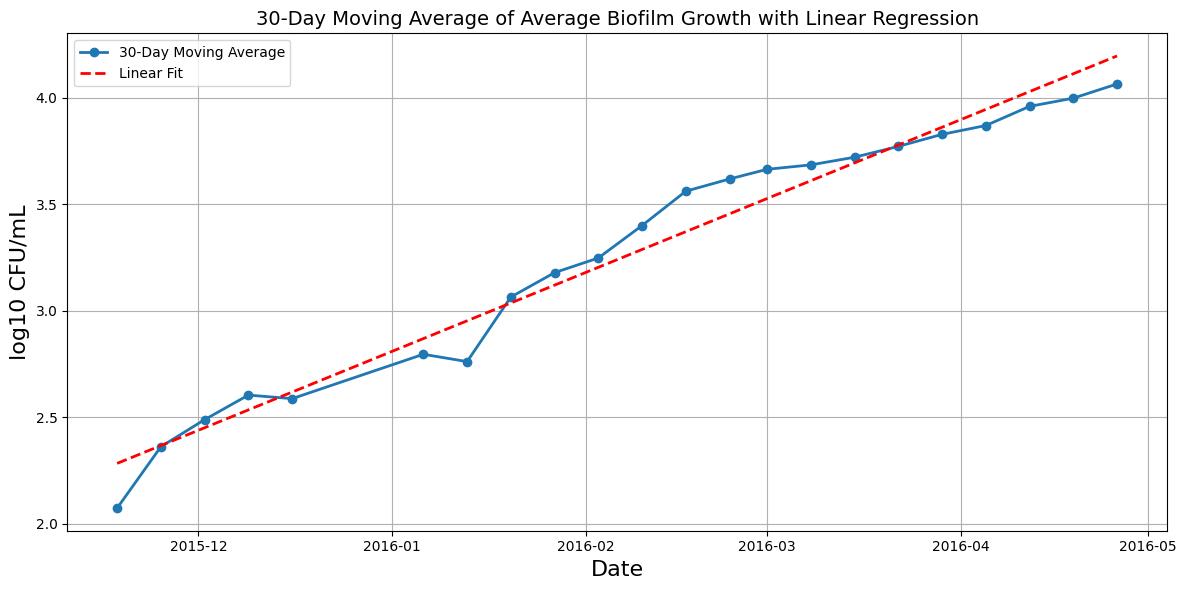

In [ ]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Your data
data = {
    "Date": pd.to_datetime(["11/18/2015", "11/25/2015", "12/2/2015", "12/9/2015",
                           "12/16/2015", "1/6/2016", "1/13/2016", "1/20/2016",
                           "1/27/2016", "2/3/2016", "2/10/2016", "2/17/2016",
                           "2/24/2016", "3/1/2016", "3/8/2016", "3/15/2016",
                           "3/22/2016", "3/29/2016", "4/5/2016", "4/12/2016",
                           "4/19/2016", "4/26/2016"]),
    "log10_CFU": [2.073, 2.650, 2.743, 2.950, 2.520, 2.917, 2.847, 3.430,
                  3.523, 3.523, 3.680, 3.653, 3.717, 3.750, 3.627, 3.860,
                  3.907, 4.000, 3.957, 4.077, 4.053, 4.240]
}

# Create DataFrame
df = pd.DataFrame(data)

# Compute days since first date
df["Days"] = (df["Date"] - df["Date"].iloc[0]).dt.days

# Sort and index by Date
df.sort_values("Date", inplace=True)
df.set_index("Date", inplace=True)

# Calculate 30-day moving average
df["log10_CFU_MA30"] = df["log10_CFU"].rolling(window="30D").mean()

# Drop rows with NaN
df_ma = df.dropna(subset=["log10_CFU_MA30"]).copy()
df_ma["Days"] = (df_ma.index - df_ma.index.min()).days

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_ma["Days"], df_ma["log10_CFU_MA30"])

# Prepare regression line
regression_line = intercept + slope * df_ma["Days"]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_ma.index, df_ma["log10_CFU_MA30"], marker='o', label="30-Day Moving Average", linewidth=2)
plt.plot(df_ma.index, regression_line, linestyle="--", color='red', label="Linear Fit", linewidth=2)
plt.xlabel("Date", fontsize=16)
plt.ylabel("log10 CFU/mL", fontsize=16)
plt.title("30-Day Moving Average of  Average Biofilm Growth with Linear Regression", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


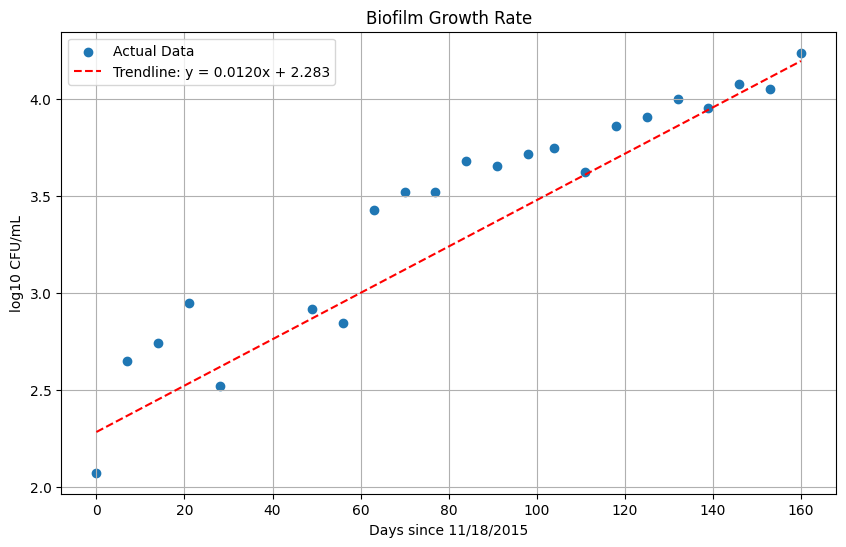

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df["Days"], df["log10_CFU"], label="Actual Data")
plt.plot(df["Days"], intercept + slope * df["Days"], 'r--',
         label=f"Trendline: y = {slope:.4f}x + {intercept:.3f}")
plt.xlabel("Days since 11/18/2015")
plt.ylabel("log10 CFU/mL")
plt.title("Biofilm Growth Rate")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# Prepare time and smoothed CFU/mL data
df_fit = df_avg.dropna(subset=["CFU_MA_30"]).copy()
df_fit["Days"] = (df_fit["Date"] - df_fit["Date"].min()).dt.days
t_model = df_fit["Days"].values
y_model = df_fit["CFU_MA_30"].values

# Define the full biofilm model
def full_model(t, y, N, r_b, Kc, sigma, S0, k_attach, k_detach):
    B, S = y
    mu_b = r_b * N / (Kc * B + N) * (1 - B / (sigma * S))
    dBdt = mu_b * B + k_attach * (1 - B / (sigma * S)) - k_detach * B
    dSdt = - (mu_b * B + k_attach * (1 - B / (sigma * S))) / sigma + (k_detach * B) / sigma
    return [dBdt, dSdt]

# Wrapper for solve_ivp integration
def simulate_full(params):
    N, r_b, Kc, sigma, S0, k_attach, k_detach = params
    y0 = [y_model[0], S0]
    sol = solve_ivp(lambda t, y: full_model(t, y, N, r_b, Kc, sigma, S0, k_attach, k_detach),
                    [t_model[0], t_model[-1]], y0, t_eval=t_model, method='RK45')
    return sol.y[0] if sol.success else np.full_like(t_model, np.nan)

# Objective function to minimize squared error
def objective(params):
    y_pred = simulate_full(params)
    if np.any(np.isnan(y_pred)) or np.any(np.iscomplex(y_pred)):
        return np.inf
    return np.sum((y_pred - y_model)**2)

# Initial guesses and bounds
initial_guess = [0.05, 0.02, 0.5, 1e6, 6.0, 0.5, 10.0]
bounds = [(0.001, 1), (0.001, 1), (0.001, 10), (1e3, 1e8), (1, 20), (0.001, 10), (0.001, 1e5)]

# Run optimization
result = minimize(objective, initial_guess, bounds=bounds)
best_params = result.x
fit_curve = simulate_full(best_params)

# Calculate R^2
ss_res = np.sum((fit_curve - y_model) ** 2)
ss_tot = np.sum((y_model - np.mean(y_model)) ** 2)
r_squared_final = 1 - ss_res / ss_tot

# Add result to dataframe
df_fit["Model_Fit"] = fit_curve

best_params, r_squared_final
print(best_params)

NameError: name 'df_avg' is not defined